# Extracting contour lines

**What does this notebook do?** 

This notebook demonstrates how to use the `contour_extract` function to extract contours from a two-dimensional array, either as arrays of xy coordinates or as shapefiles with custom attribute fields. Contours can be extracted either from digital elevation data (DEMs), or from any other 2D array such as extracting waterline boundaries from Landsat-derived Normalized Difference Water Index (NDWI) data.

**Requirements:**

You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea` 

This notebook uses an external function called `contour_extract`. This function is available in the `10_Scripts` folder of the [dea-notebooks Github repository](https://github.com/GeoscienceAustralia/dea-notebooks/tree/master/10_Scripts). Note that these functions have been developed by DEA users, not the DEA development team, and so are provided without warranty. If you find an error or bug in the functions, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated function back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

**Date:** September 2018

**Author:** Robbi Bishop-Taylor

## Load modules

In [3]:
# Import modules
import os
import sys
import datacube 
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# Import external dea-notebooks functions using relative link to Scripts directory
sys.path.append('../10_Scripts')
import SpatialTools

# Set up datacube instance
dc = datacube.Datacube(app='Contour extraction')


## Load in elevation data
Here we use `dc.load` to import Shuttle Radar Topography Mission (SRTM) Digital Elevation Model (DEM) data for Canberra. This returns a hydrologically enforced digital elevation model (DEM-H):

In [4]:
# Elevation query
elevation_query = {
        'lat': (-35.25, -35.35),
        'lon': (149.05, 149.17),
        'output_crs': 'EPSG:3577',
        'resolution': (-25, 25)
}

# Load in DEM data
elevation_data = dc.load(product='srtm_dem1sv1_0', **elevation_query)
elevation_data

<xarray.Dataset>
Dimensions:  (time: 1, x: 492, y: 500)
Coordinates:
  * time     (time) datetime64[ns] 2014-12-15T14:58:44
  * y        (y) float64 -3.953e+06 -3.953e+06 -3.953e+06 -3.953e+06 ...
  * x        (x) float64 1.542e+06 1.542e+06 1.542e+06 1.542e+06 1.542e+06 ...
Data variables:
    dem      (time, y, x) float32 653.0692 652.3962 651.54095 649.54224 ...
    dem_s    (time, y, x) float32 651.44354 651.31757 650.7917 650.1855 ...
    dem_h    (time, y, x) float32 651.2039 651.0723 650.6889 650.26843 ...
Attributes:
    crs:      EPSG:3577

Create a terrain-coloured colour map and plot the DEM-H data:

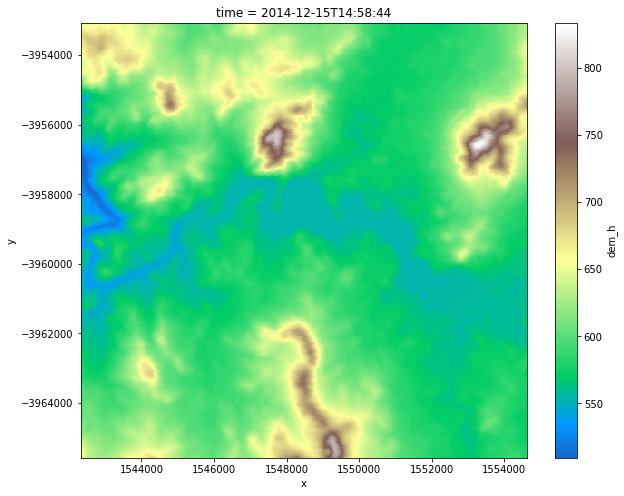

In [5]:
# Create a custom colourmap for the DEM 
colors_terrain = plt.cm.terrain(np.linspace(0.08, 1, 200))
cmap_terrain = mpl.colors.LinearSegmentedColormap.from_list('terrain', colors_terrain)

# Plot the elevation; `squeeze` removes the uncessessary time dimension
plt.figure(figsize=(10, 8))
elevation_data.dem_h.squeeze('time').plot(cmap=cmap_terrain)


## Contour extraction
The `SpatialTools.contour_extract` function uses `skimage.measure.find_contours` to extract contour lines from a two-dimensional array. This can be elevation, or any other 2D array.

We can extract contours from the elevation array above by passing in a list of `z_values` or elevations and the the array we want to extract from. Arrays can either be numpy arrays or xarray DataArrays, but they must have only two dimensions. If the array has a time dimension, remove it by using `.isel(time=0)` or `.squeeze('time')` on the array first. We also need to provide a `crs` and an `affine` object, both of which can be obtained from the xarray DataArray.

The function will then extract a contour for each value in `z_values`, skipping any contour elevation that is not found in the array (e.g. 850 m below):

In [13]:
# Remove the time dimension and verify we have only two dimensions
elevation_2d = elevation_data.dem_h.squeeze('time')
print(f'The dataset has {len(elevation_2d.shape)} dimensions: {elevation_2d.shape}\n')

# Extract contours
contour_dict = SpatialTools.contour_extract(z_values=range(550, 900, 50),
                                            ds_array=elevation_2d,
                                            ds_crs=elevation_2d.geobox.crs,
                                            ds_affine=elevation_2d.geobox.affine)

The dataset has 2 dimensions: (500, 492)

Extracting contour 550
Extracting contour 600
Extracting contour 650
Extracting contour 700
Extracting contour 750
Extracting contour 800
Extracting contour 850
    No data for contour 850; skipping


The default output from the function is an ordered dictionary with contour z-values as the dict keys, and lists of multiple xy point arrays (one for each individual contour line) as dict values. For example, there were 13 individual contour lines extracted for height 650 m:

In [14]:
# Print dictionary keys
print(contour_dict.keys())

# Inspect the 650m contour height to see what contours were extracted
print(f'There were {len(contour_dict[650])} individual contours extracted for contour height 650')

odict_keys([550, 600, 650, 700, 750, 800])
There were 13 individual contours extracted for contour height 650


Each individual contour line is stored as an array of x (first column) and y (second column) values:

In [15]:
# Inspect one of the thirteen 650 m contours:
contour_dict[650][2]

array([[ 1554612.5       , -3954025.0118135 ],
       [ 1554599.78116994, -3954012.5       ],
       [ 1554588.43112046, -3953987.5       ],
       [ 1554587.5       , -3953983.96815428],
       [ 1554582.75710088, -3953962.5       ],
       [ 1554577.84765509, -3953937.5       ],
       [ 1554587.5       , -3953924.96909219],
       [ 1554599.96909219, -3953912.5       ],
       [ 1554591.10785886, -3953887.5       ],
       [ 1554587.5       , -3953877.54205401],
       [ 1554581.76362347, -3953862.5       ],
       [ 1554573.65109152, -3953837.5       ],
       [ 1554572.73352082, -3953812.5       ],
       [ 1554572.00442683, -3953787.5       ],
       [ 1554577.44306353, -3953762.5       ],
       [ 1554587.5       , -3953739.98251995],
       [ 1554588.66800691, -3953737.5       ],
       [ 1554612.5       , -3953723.83956802]])

### Exporting shapefiles
Mostly, however, you will want to use the function to output a shapefile of contour lines by specifying an output path for `output_shp`. Here we extract 10 m contours and save them to a shapefile called `extracted_contours.shp`:

In [16]:
# Extract contours and export to a shapefile
contour_dict = SpatialTools.contour_extract(z_values=range(510, 840, 10),
                                            ds_array=elevation_data.dem_h.squeeze('time'),
                                            ds_crs=elevation_data.geobox.crs,
                                            ds_affine=elevation_data.geobox.affine,
                                            output_shp='extracted_contours.shp')

Extracting contour 510
Extracting contour 520
Extracting contour 530
Extracting contour 540
Extracting contour 550
Extracting contour 560
Extracting contour 570
Extracting contour 580
Extracting contour 590
Extracting contour 600
Extracting contour 610
Extracting contour 620
Extracting contour 630
Extracting contour 640
Extracting contour 650
Extracting contour 660
Extracting contour 670
Extracting contour 680
Extracting contour 690
Extracting contour 700
Extracting contour 710
Extracting contour 720
Extracting contour 730
Extracting contour 740
Extracting contour 750
Extracting contour 760
Extracting contour 770
Extracting contour 780
Extracting contour 790
Extracting contour 800
Extracting contour 810
Extracting contour 820
Extracting contour 830

Exporting contour shapefile to extracted_contours.shp


We can import the resulting shapefile using Geopandas to verify it exported correctly. By default, the shapefile includes a single `z_value` attribute field with one feature per input value in `z_values`:

In [17]:
# Import shapefile using geopandas
contour_shp = gpd.read_file('extracted_contours.shp')
contour_shp.head()

I am densified (5 elements)
I am densified (5 elements)


,z_value,geometry
0,510.0,"(LINESTRING (1542337.5 -3956930.487982333, 154..."
1,520.0,"LINESTRING (1542337.5 -3957156.070412518, 1542..."
2,530.0,"(LINESTRING (1542337.5 -3959154.630361252, 154..."
3,540.0,"(LINESTRING (1542337.5 -3959290.915682619, 154..."
4,550.0,"(LINESTRING (1542337.5 -3955470.764855981, 154..."


We can plot the contours over the top of the original elevation array to verify they are in the correct locations:

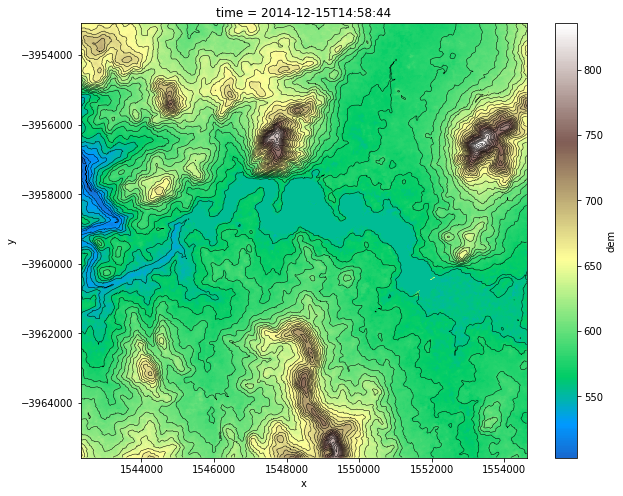

In [18]:
# Plot contours over the top of elevation array
fig, ax = plt.subplots(figsize=(10, 8))
elevation_data.dem.isel(time=0).plot(ax=ax, cmap=cmap_terrain)
contour_shp.plot(ax=ax, linewidth=0.5, color='black')

### Custom shapefile attributes
By default, the shapefile includes a single `z_value` attribute field with one feature per input value in `z_values`. We can instead pass custom attributes to the output
shapefile using the `attribute_data` and `attribute_dtypes` parameters. For example, we might want a custom column called `elev_cm` with heights in cm instead of m, and a `location` column giving the location (Canberra). 

We can achieve this by passing in a dict with field names as keys, and a list of values of the same length as `z_values`. When passing in custom attributes, we also need to manually set the dtypes for the output fields using an `attribute_dtypes` dictionary. The dict should have the same keys/field names as declared in `attribute_data`, and values which include 'int', 'str', 'datetime, and 'float:X.Y', where X is the minimum number of characters before the decimal place, and Y is the number of characters after the decimal place:

In [19]:
# Set up dicts with the attribute field name as the dict key, and lists of values of the same
# length as `z_values`:
custom_attrs = {'elev_cm': [55000, 60000, 65000, 70000, 75000, 80000, 85000],
               'location': ['Canberra', 'Canberra', 'Canberra', 'Canberra', 
                            'Canberra', 'Canberra', 'Canberra']}
custom_attrs_dtypes = {'elev_cm': 'int', 'location': 'str'}

# Extract contours with custom attribute fields:
contour_dict = SpatialTools.contour_extract(z_values=range(550, 900, 50),
                                            ds_array=elevation_data.dem_h.squeeze('time'),
                                            ds_crs=elevation_data.geobox.crs,
                                            ds_affine=elevation_data.geobox.affine,
                                            output_shp='extracted_contours_attrs.shp',
                                            attribute_data=custom_attrs,
                                            attribute_dtypes=custom_attrs_dtypes)

# Import shapefile using geopandas to verify that the shapefile includes the new attributes:
contour_shp = gpd.read_file('extracted_contours_attrs.shp')
contour_shp

Extracting contour 550
Extracting contour 600
Extracting contour 650
Extracting contour 700
Extracting contour 750
Extracting contour 800
Extracting contour 850
    No data for contour 850; skipping

Exporting contour shapefile to extracted_contours_attrs.shp
I am densified (6 elements)
I am densified (6 elements)


,elev_cm,location,geometry
0,55000,Canberra,"(LINESTRING (1542337.5 -3955470.764855981, 154..."
1,60000,Canberra,"(LINESTRING (1545252.210436996 -3953087.5, 154..."
2,65000,Canberra,"(LINESTRING (1543443.610875806 -3953087.5, 154..."
3,70000,Canberra,"(LINESTRING (1544862.5 -3955595.512401243, 154..."
4,75000,Canberra,"(LINESTRING (1553162.5 -3957020.618084073, 155..."
5,80000,Canberra,"(LINESTRING (1547737.5 -3956521.204322249, 154..."


## Contours from non-elevation datasets
The input array does not need to be elevation data: contours can be extracted from any two-dimensional array. For example, we can use the function to extract the boundary between land and water. First, import some sample Landsat data and calculate a simple Normalized Difference Water Index (NDWI). This index will have high values where a pixel is likely to be open water (e.g. NDWI > 0, or red colours below):

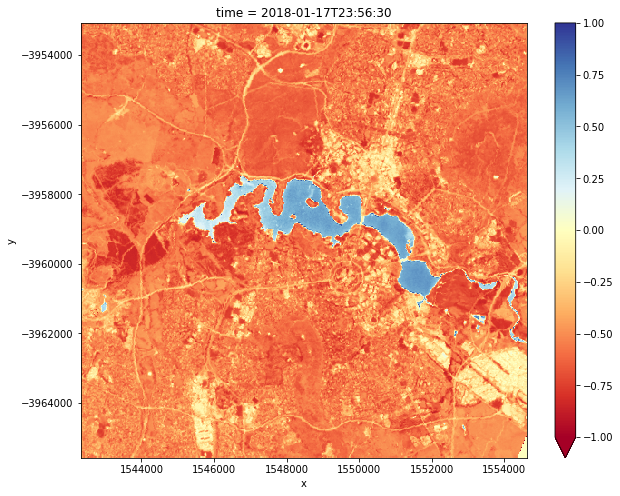

In [20]:
# Landsat query
landsat_query = {
        'lat': (-35.25, -35.35),
        'lon': (149.05, 149.17),
        'time': ('2018-01-15', '2018-01-18'),
        'measurements': ['red', 'green', 'blue', 'nir'],
        'output_crs': 'EPSG:3577',
        'resolution': (-25, 25)
}

# Load Landsat 8 data
landsat_data = dc.load(product='ls8_nbart_albers', 
                       group_by = 'solar_day', 
                       **landsat_query)

# Compute NDWI
landsat_ndwi = (landsat_data.green - landsat_data.nir) / \
               (landsat_data.green + landsat_data.nir)
    
# Plot
fig, ax = plt.subplots(figsize=(10, 8))
landsat_ndwi.plot(vmin=-1.0, vmax=1.0, cmap='RdYlBu')


We can now identify the land-water boundary by extracting a single 0 NDWI contour:

Extracting contour 0

Exporting contour shapefile to extracted_contours_ndwi.shp


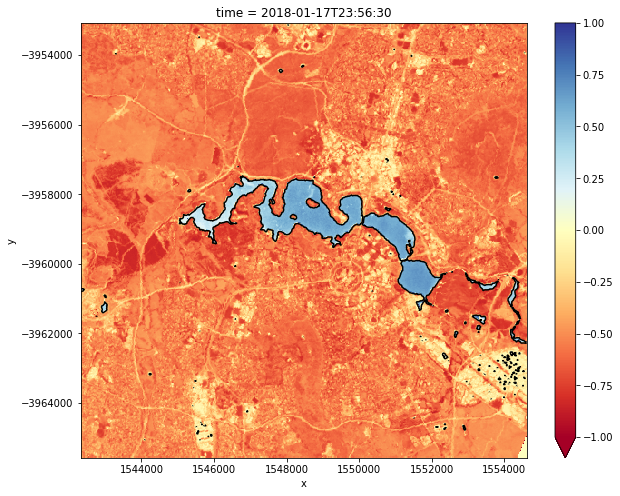

In [21]:
# Extract contours with custom attribute fields:
contour_dict = SpatialTools.contour_extract(z_values=[0],
                                            ds_array=landsat_ndwi.squeeze('time'),
                                            ds_crs=elevation_data.geobox.crs,
                                            ds_affine=elevation_data.geobox.affine,
                                            output_shp='extracted_contours_ndwi.shp')

# Import shapefile using geopandas to verify that the shapefile includes the new attributes:
contour_shp = gpd.read_file('extracted_contours_ndwi.shp')
contour_shp

# Plot contours over the top of elevation array
fig, ax = plt.subplots(figsize=(10, 8))
landsat_ndwi.plot(ax=ax, vmin=-1.0, vmax=1.0, cmap='RdYlBu')
contour_shp.plot(ax=ax, linewidth=1.5, color='black')

### Dropping small contours
The image above contains many small contours. We can optionally choose to extract only contours larger than a certain number of vertices using the `min_vertices` parameter. This can be useful for focusing on large contours, and remove possible noise in a dataset. Here we set `min_vertices=20` to keep only contours with at least 20 vertices:

Extracting contour 0

Exporting contour shapefile to extracted_contours_ndwi.shp


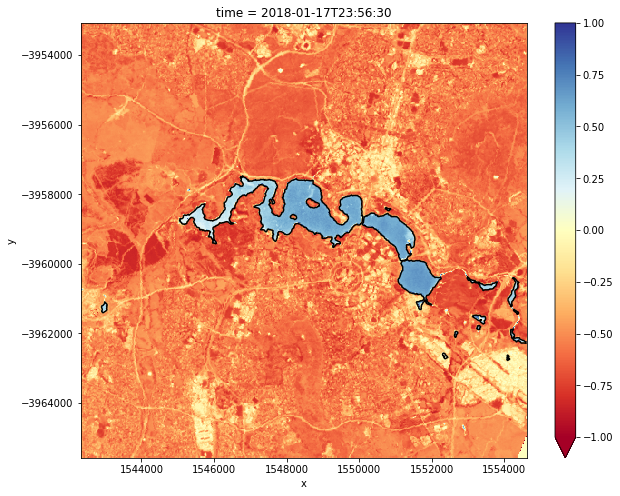

In [22]:
# Extract contours with custom attribute fields:
contour_dict = SpatialTools.contour_extract(z_values=[0],
                                            ds_array=landsat_ndwi.squeeze('time'),
                                            ds_crs=elevation_data.geobox.crs,
                                            ds_affine=elevation_data.geobox.affine,
                                            output_shp='extracted_contours_ndwi.shp',
                                            min_vertices=20)

# Import shapefile using geopandas to verify that the shapefile includes the new attributes:
contour_shp = gpd.read_file('extracted_contours_ndwi.shp')
contour_shp

# Plot contours over the top of elevation array
fig, ax = plt.subplots(figsize=(10, 8))
landsat_ndwi.plot(ax=ax, vmin=-1.0, vmax=1.0, cmap='RdYlBu')
contour_shp.plot(ax=ax, linewidth=1.5, color='black')
